# Finite Elements on a Pac-Man Mesh
This example demonstrates how to set up and solve a finite element problem on a
punctured mesh. 
The model problem under consideration is a simple diffusion-reaction problem
\begin{align*}
	-\nabla\cdot(a \, \nabla u) + c \, u &= f \quad \text{in } \Omega, \\
	u &= 0 \quad \text{on } \partial\Omega,
\end{align*}
where $a, c$ are constant scalars and $f$ is a polynomial.
The associated weak form is
\begin{align*}
	\int_\Omega a \, \nabla u \cdot \nabla v \, dx
	+ \int_\Omega c \, u \, v \, dx
	&= \int_\Omega f \, v \, dx
	\quad \forall v \in H^1_0(\Omega).
\end{align*}
In previous examples, we saw that we can evalate these integrals on each cell
$K$ in a mesh $\mathcal{T}$ of the domain $\Omega$, provided that $u$ and $v$
are elements of a *local Poisson space* $V_p(K)$.
We define the *global Poisson space* $V_p(\mathcal{T})$ as the space of
continuous functions in $H^1_0(\Omega)$ whose restriction to each cell $K$ is
an element of $V_p(K)$.
By constructing a basis $\{\phi_1, \dots, \phi_N\}$ of $V_p(\mathcal{T})$ by 
continuously "stitching" the local basis functions together,
we seek a finite element solution $\tilde{u} \in V_p(\mathcal{T})$ such that
\begin{align*}
	&\tilde{u} = \sum_{i=1}^N u_i \, \phi_i,
	\\
	&\int_\Omega a \, u_i \nabla \phi_i \cdot \nabla \phi_j \, dx
	+ \int_\Omega c \, u_i \, \phi_i \, \phi_j \, dx
	= \int_\Omega f \, \phi_j \, dx
\end{align*}

We begin by importing the usual packages, as well as the `tqdm` package for
displaying progress bars.

*Note:* This example can be run without the `tqdm` package by setting 
`verbose=False` below.

In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's set a few parameters before we go any further. 
`deg` is the polynomial degree of global Poisson space,
`n` is edge sampling parameter (as used in previous examples),
and `verbose` controls how much output we see.

**(!) WARNING:** 
Higher order spaces (`deg > 1`) are still under development.

In [2]:
deg = 1
n = 64
verbose = True

## Mesh construction
The mesh we will use for this example was constructed in 
[Example 0](ex0-mesh-building.ipynb).
For convenience, the same mesh can be constructed by calling the `pacman_mesh`
function in the `mesh.meshlib` module.

In [3]:
# define mesh
# T = pf.meshlib.pacman(verbose=verbose)
T = pf.meshlib.pacman_subdiv(verbose=verbose)

Building planar mesh...
planar_mesh:
	num_verts: 17
	num_edges: 25
	num_cells: 11


## Build global function space 
The global function space $V_p(\mathcal{T})\subset H^1(\Omega)$ 
is the space of continuous functions such that each function belongs to 
$V_p(K)$ when restricted to any cell $K\in\mathcal{T}$.
(Note that we use `deg` to denote the polynomial degree $p$.)

To proceed with the computation, we define the quadrature scheme(s) used to 
parameterize the edges of the mesh.

In [4]:
# TODO: this should really be done automatically
q_trap = pf.quad(qtype="trap", n=n)
q_kress = pf.quad(qtype="kress", n=n)
quad_dict = {"kress": q_kress, "trap": q_trap}

The global function space `V` is built from the mesh `T`, along with the `deg`
parameter and the information necessary to parameterize the edges of the mesh.

In [5]:
V = pf.global_function_space(T=T, deg=deg, quad_dict=quad_dict, verbose=verbose)

Building edge spaces...


100%|██████████| 25/25 [00:00<00:00, 509.43it/s]

global_function_space:
	deg: 1
	num_funs: 38
	num_bubb_funs: 0
	num_vert_funs: 17
	num_edge_funs: 21


## Define a bilinear form
The bilinear form 
\begin{align*}
	B(u,v) = 
	a \, \int_\Omega \nabla u \cdot \nabla v ~dx
	+ c \, \int_\Omega u \, v ~dx
\end{align*}
and the right-hand side linear functional
\begin{align*}
	F(v) = \int_\Omega f \, v ~dx
\end{align*}
are declared as follows,
with `diffusion_coefficient` $a = 1$, 
`reaction_coefficient` $c = 1$,
and `rhs_poly` $f(x) = 1 \cdot x^{(0, 0)}$.

In [6]:
B = pf.bilinear_form(
    diffusion_constant=1.0,
    reaction_constant=1.0,
    rhs_poly=pf.polynomial([[1.0, 0, 0]]),
)
print(B)

bilinear_form:
	diffusion_constant: 1.0
	reaction_constant: 1.0
	rhs_poly: + (1.0)   


## Set up the finite element solver
A finite element solver needs two things: the global function space and the bilinear form. 

In [7]:
S = pf.solver(V, B)

To assemble the matrix and right-hand side vector for the global system, we 
call the `assemble()` method.
Zero Dirichlet boundary conditions are incorporated by default.

This can take a while. You may want to grab a cup of coffee.

In [8]:
S.assemble(verbose=verbose)

Cell      1 /     11


Setting up Nyström solver... 1024 sampled points on 8 edges
Computing function metadata...


100%|██████████| 9/9 [01:05<00:00,  7.33s/it]


Finding interior values...


100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 9/9 [01:00<00:00,  6.71s/it]


Cell      2 /     11
Setting up Nyström solver... 512 sampled points on 4 edges
Computing function metadata...


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Finding interior values...


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Cell      3 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 301.34it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 170.62it/s]


Cell      4 /     11
Setting up Nyström solver... 1152 sampled points on 9 edges
Computing function metadata...


100%|██████████| 15/15 [01:56<00:00,  7.80s/it]


Finding interior values...


100%|██████████| 15/15 [00:48<00:00,  3.23s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 15/15 [01:59<00:00,  8.00s/it]


Cell      5 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 608.46it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 149.46it/s]


Cell      6 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 177.13it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 212.05it/s]


Cell      7 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 575.61it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 227.48it/s]


Cell      8 /     11
Setting up Nyström solver... 1152 sampled points on 9 edges
Computing function metadata...


100%|██████████| 11/11 [01:27<00:00,  7.92s/it]


Finding interior values...


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 11/11 [01:29<00:00,  8.14s/it]


Cell      9 /     11
Setting up Nyström solver... 768 sampled points on 6 edges
Computing function metadata...


100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Finding interior values...


100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 12/12 [00:45<00:00,  3.83s/it]


Cell     10 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 103.37it/s]


Finding interior values...


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 92.40it/s]


Cell     11 /     11
Setting up Nyström solver... 128 sampled points on 1 edge
Computing function metadata...


100%|██████████| 3/3 [00:00<00:00, 538.19it/s]


Finding interior values...


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Evaluating bilinear form and right-hand side...


100%|██████████| 3/3 [00:00<00:00, 186.74it/s]


The `matplotlib.pyplot` module has a handy function for inspecting the sparsity
pattern of a matrix.  Let's take a look at the global matrix.

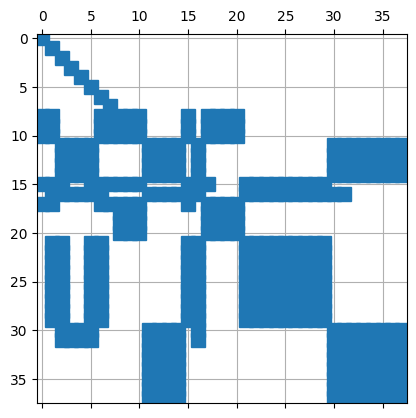

In [9]:
plt.figure()
plt.spy(S.glob_mat)
plt.grid("minor")
plt.show()

## Solving the global linear system
To solve the system we worked hard to set up, we can call the `solve()` method
on the `solver` object.

In [10]:
S.solve()

## Plot solution
We can visualize the solution by calling the `plot_solution()` method on the 
solver object.
There are two types of plots available: 
a conventional contour plot (`fill=False`)
or a heat map (`fill=True`).
To view the figure in this notebook, set `show_fig = True`.
To save it to a file, set `save_fig = True` and select a filename.

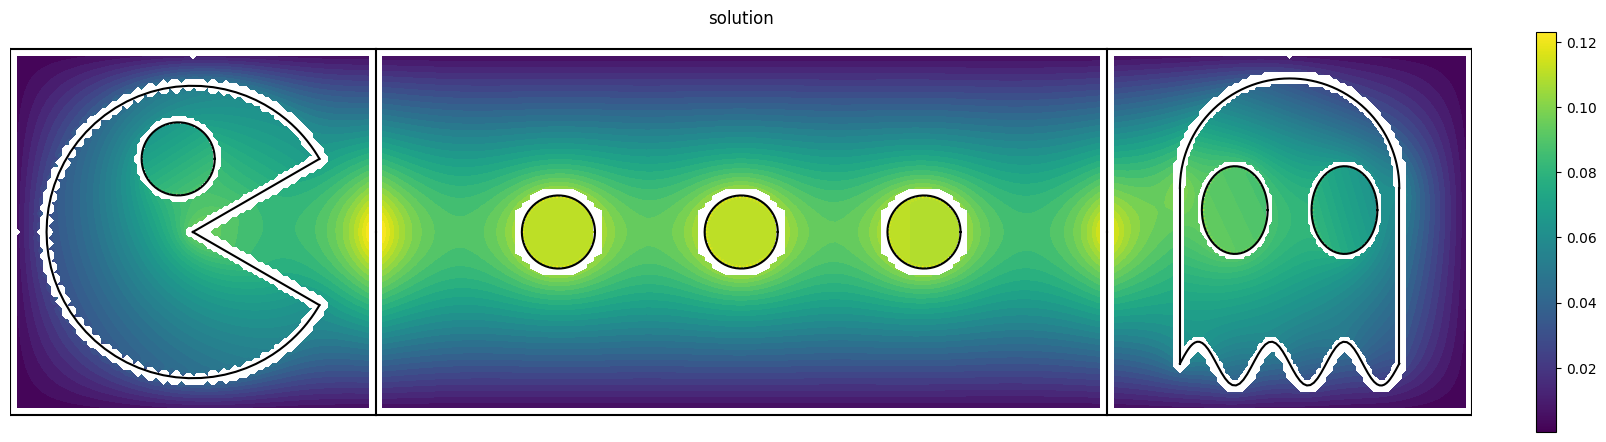

In [11]:
S.plot_solution(
    title="solution",
    show_fig=True,
    save_fig=False,
    filename="out/png/solution_heat.png",
    fill=True,
)

## Plot global basis functions
Let's take a look at the global basis functions by using the 
`plot_linear_combo()` method.

Plotting basis functions...


  0%|          | 0/38 [00:00<?, ?it/s]

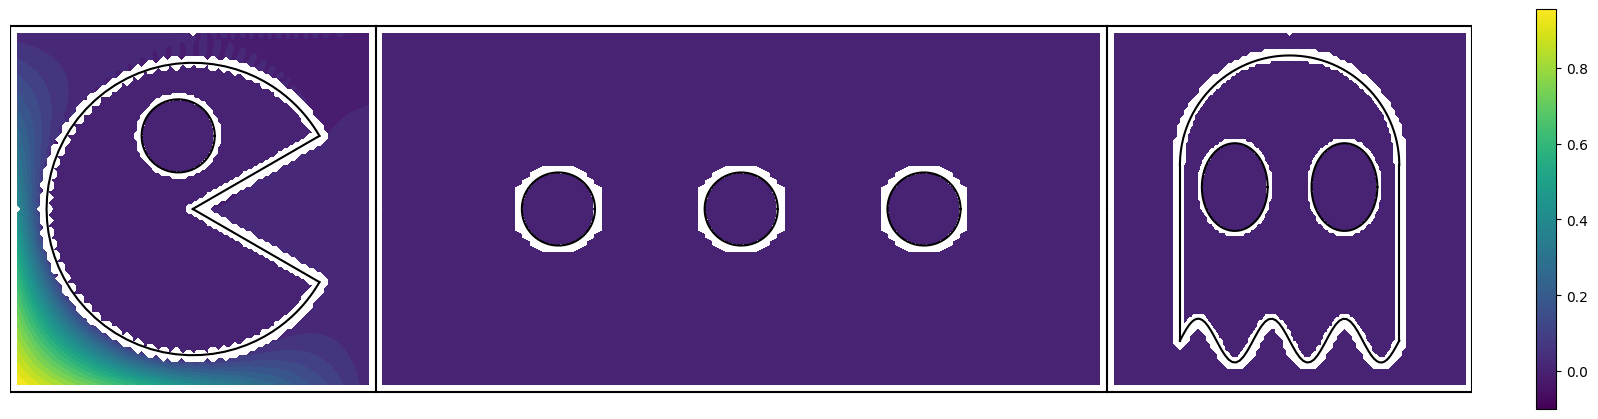

  3%|▎         | 1/38 [00:05<03:40,  5.95s/it]

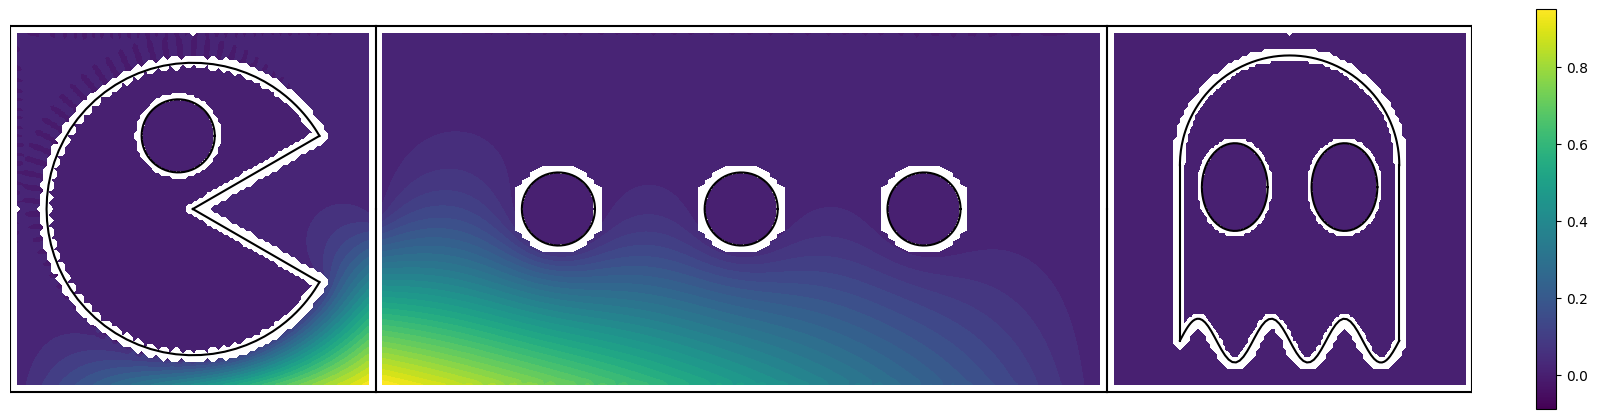

  5%|▌         | 2/38 [00:12<03:37,  6.05s/it]

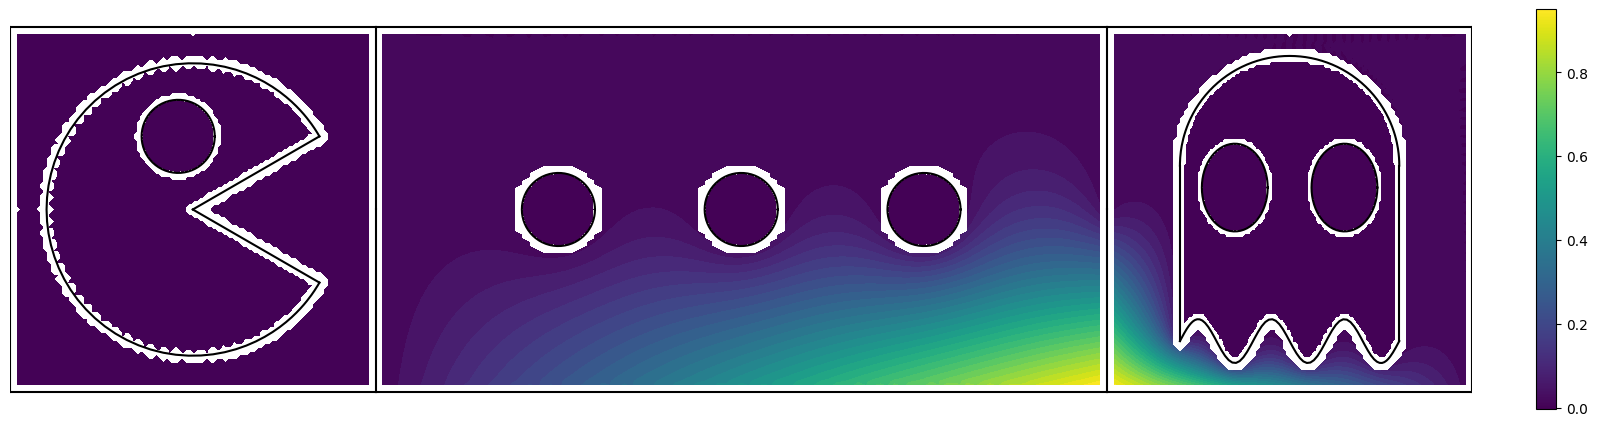

  8%|▊         | 3/38 [00:17<03:24,  5.86s/it]

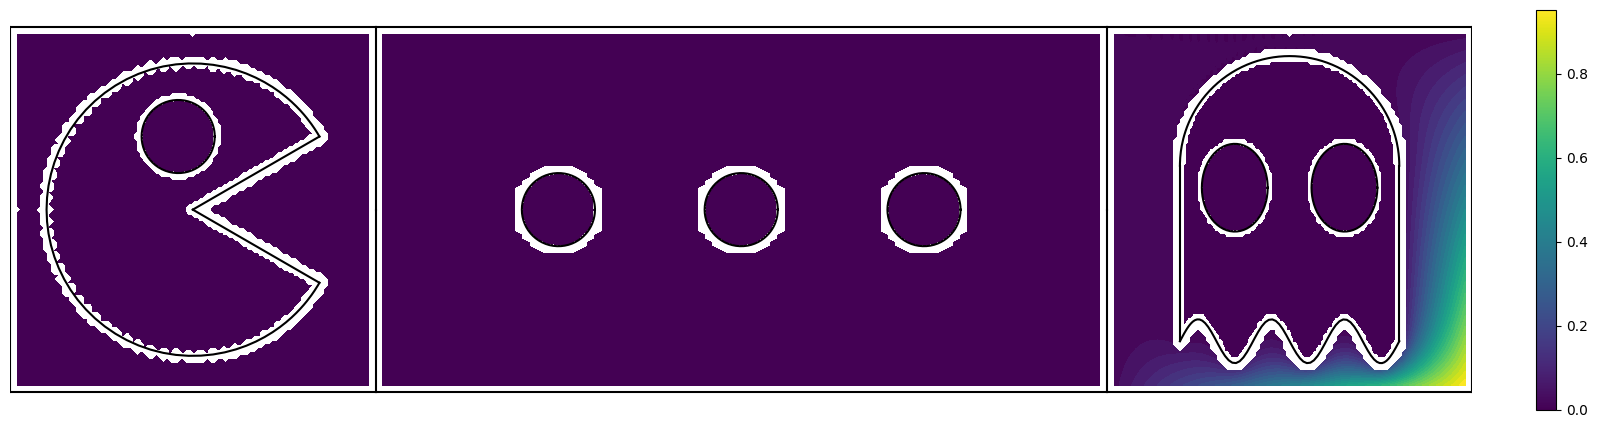

 11%|█         | 4/38 [00:24<03:25,  6.04s/it]

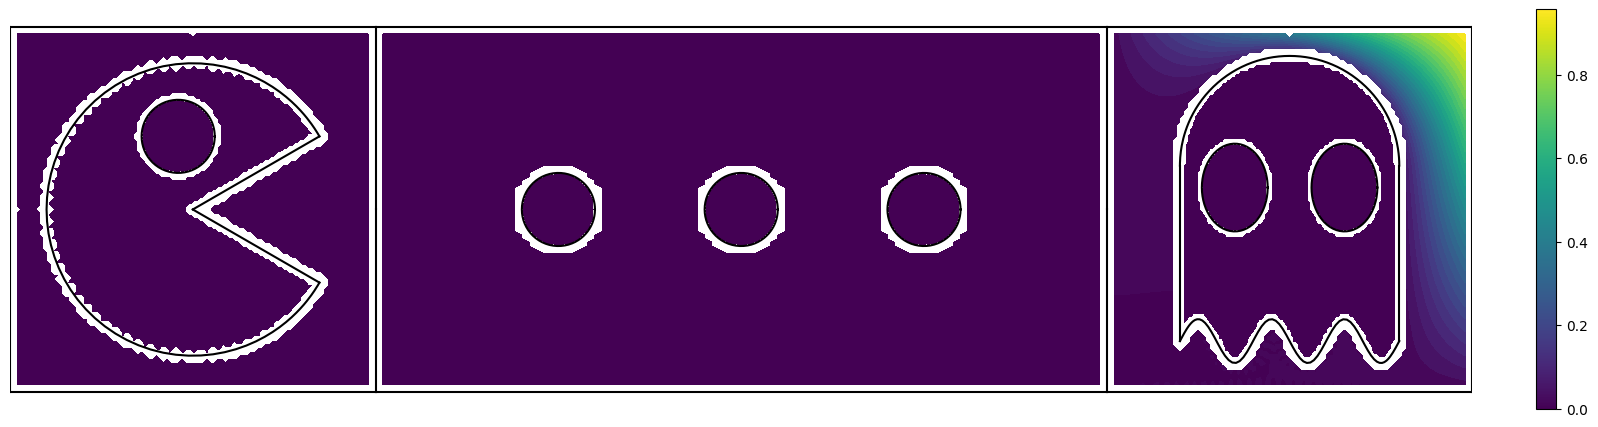

 13%|█▎        | 5/38 [00:29<03:16,  5.94s/it]

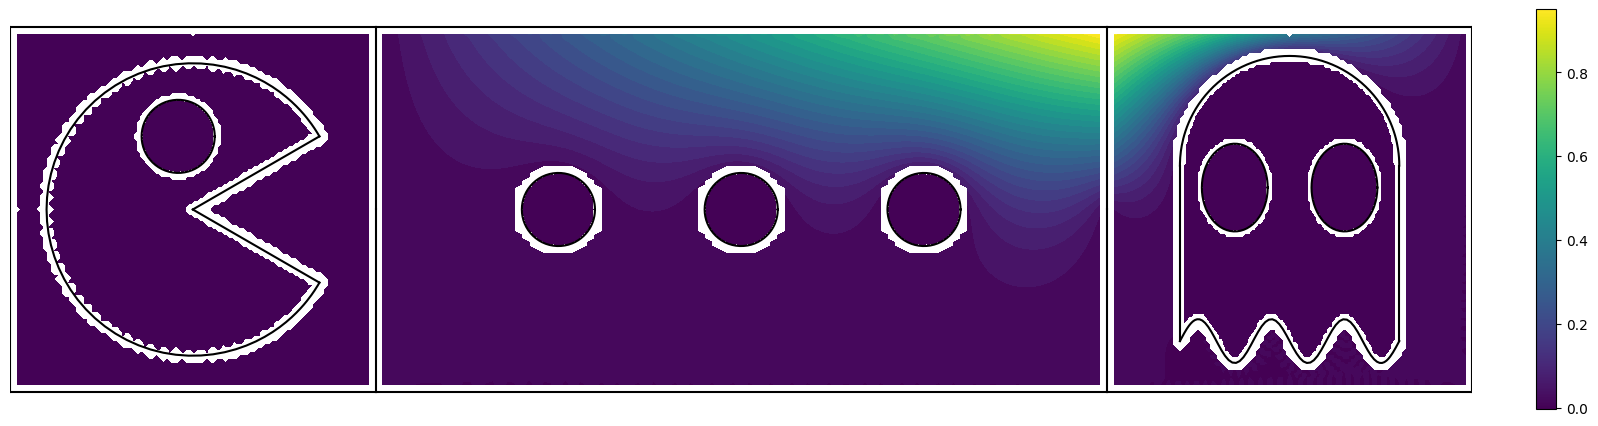

 16%|█▌        | 6/38 [00:35<03:10,  5.96s/it]

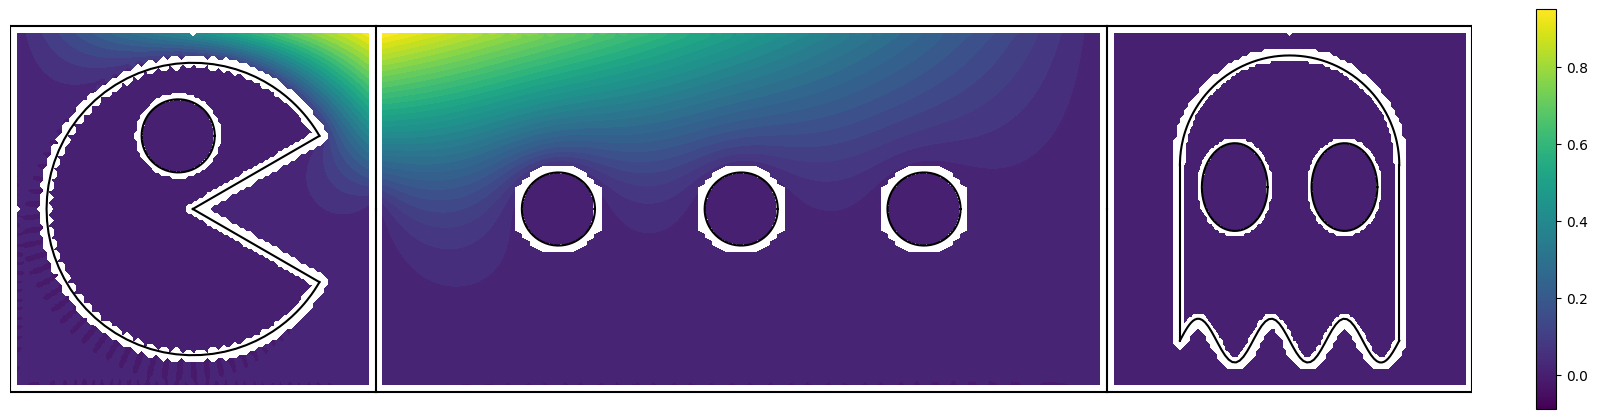

 18%|█▊        | 7/38 [00:41<03:01,  5.84s/it]

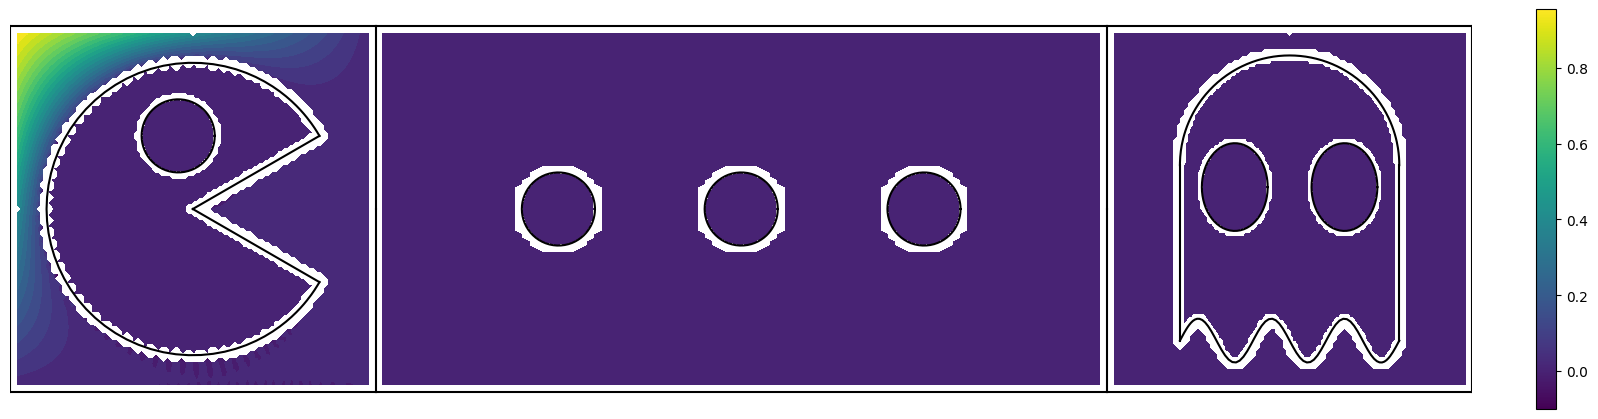

 21%|██        | 8/38 [00:46<02:51,  5.70s/it]

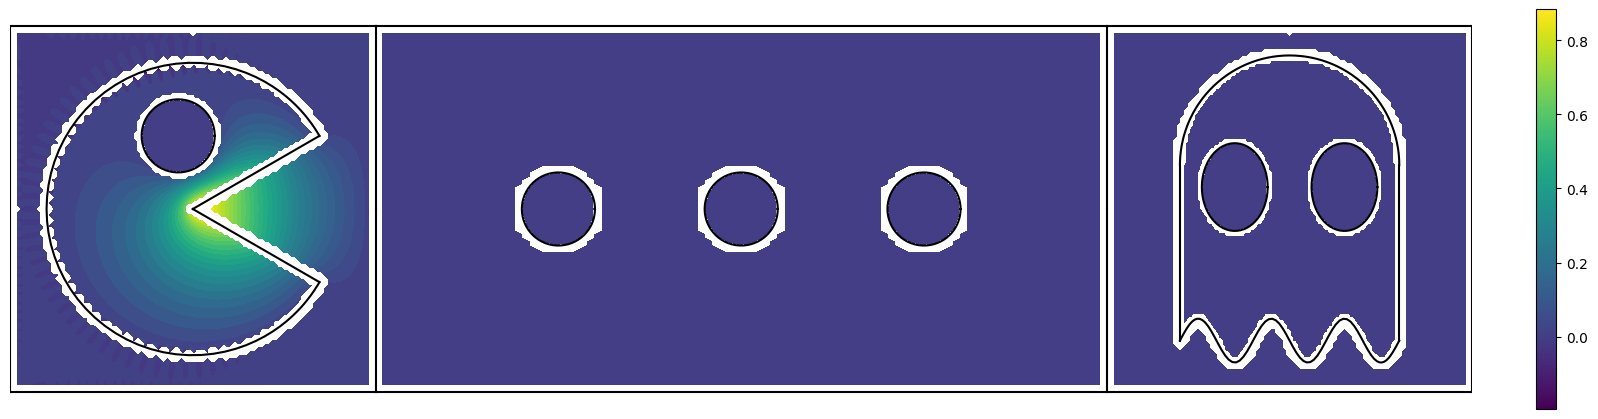

 24%|██▎       | 9/38 [00:51<02:40,  5.52s/it]

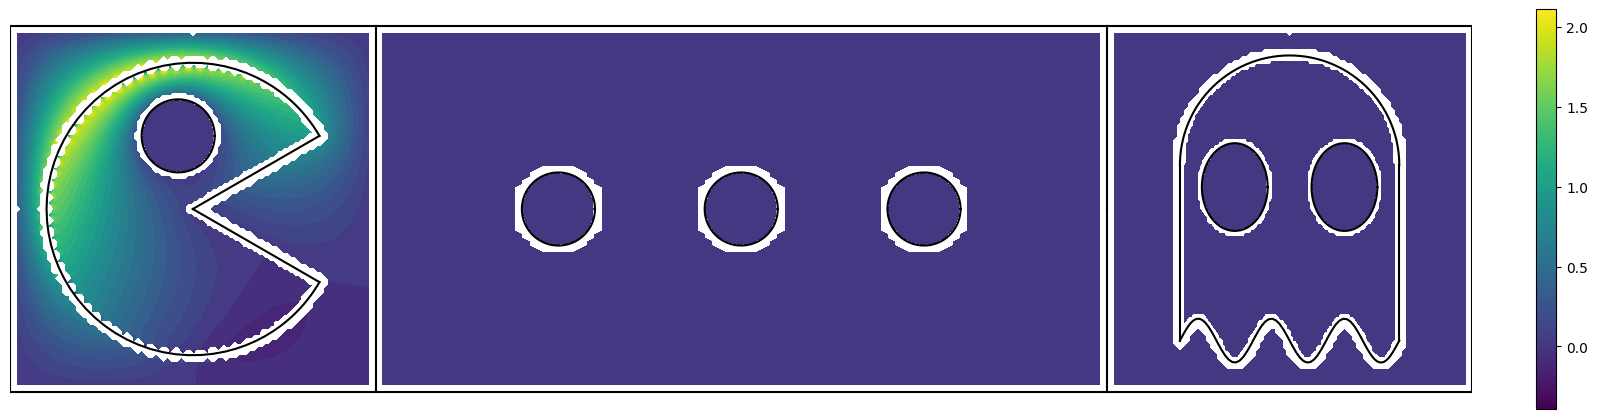

 26%|██▋       | 10/38 [00:57<02:33,  5.48s/it]

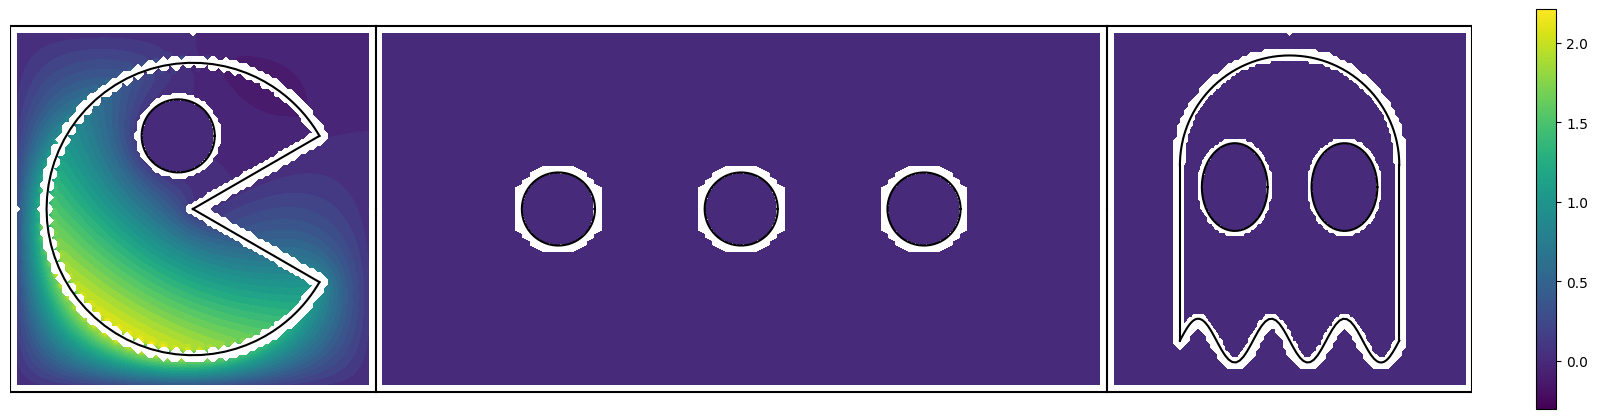

 29%|██▉       | 11/38 [01:02<02:28,  5.49s/it]

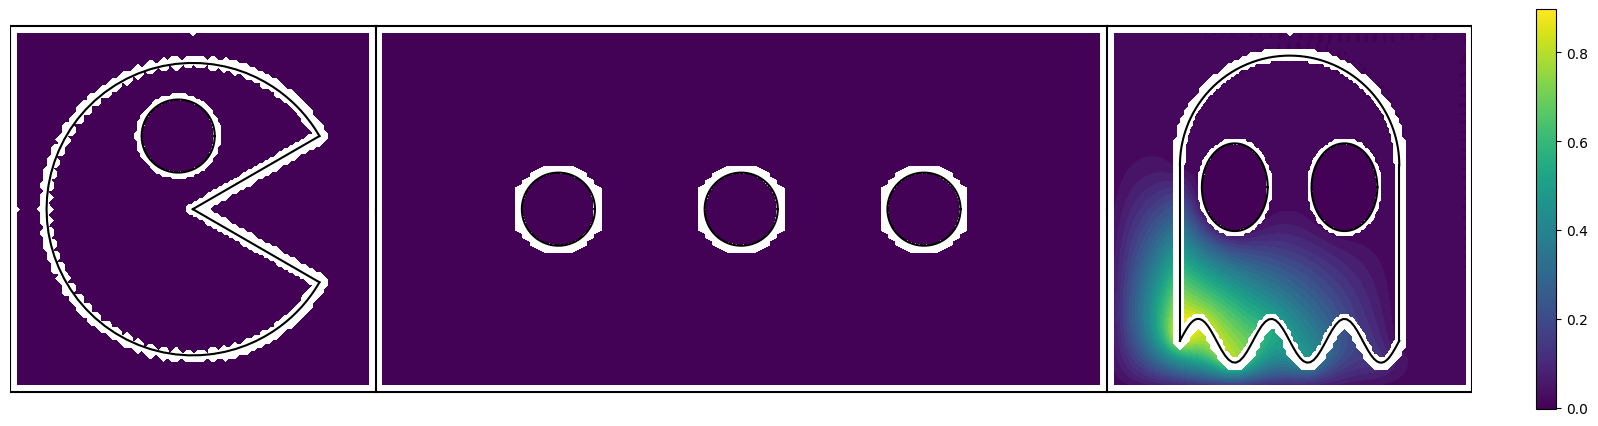

 32%|███▏      | 12/38 [01:08<02:23,  5.54s/it]

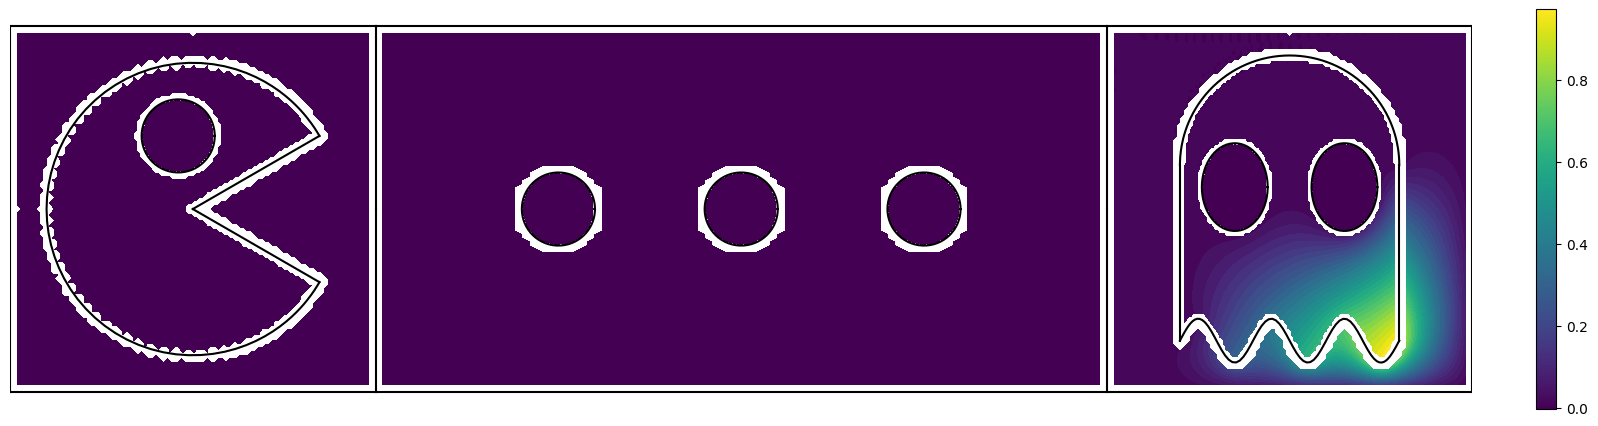

 34%|███▍      | 13/38 [01:13<02:16,  5.48s/it]

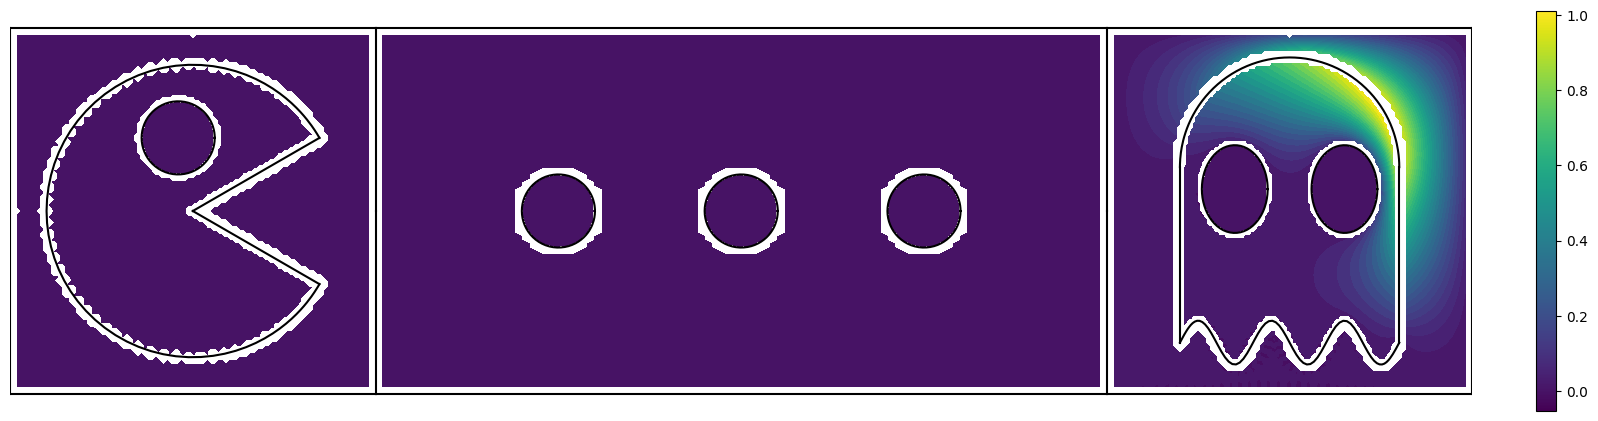

 37%|███▋      | 14/38 [01:19<02:11,  5.46s/it]

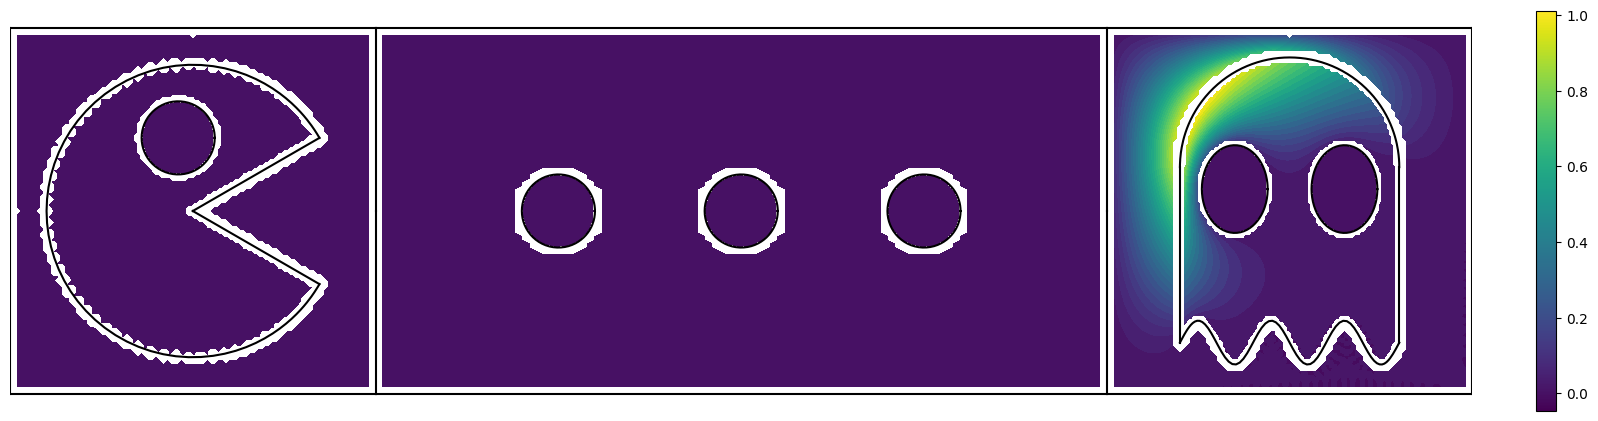

 39%|███▉      | 15/38 [01:24<02:04,  5.43s/it]

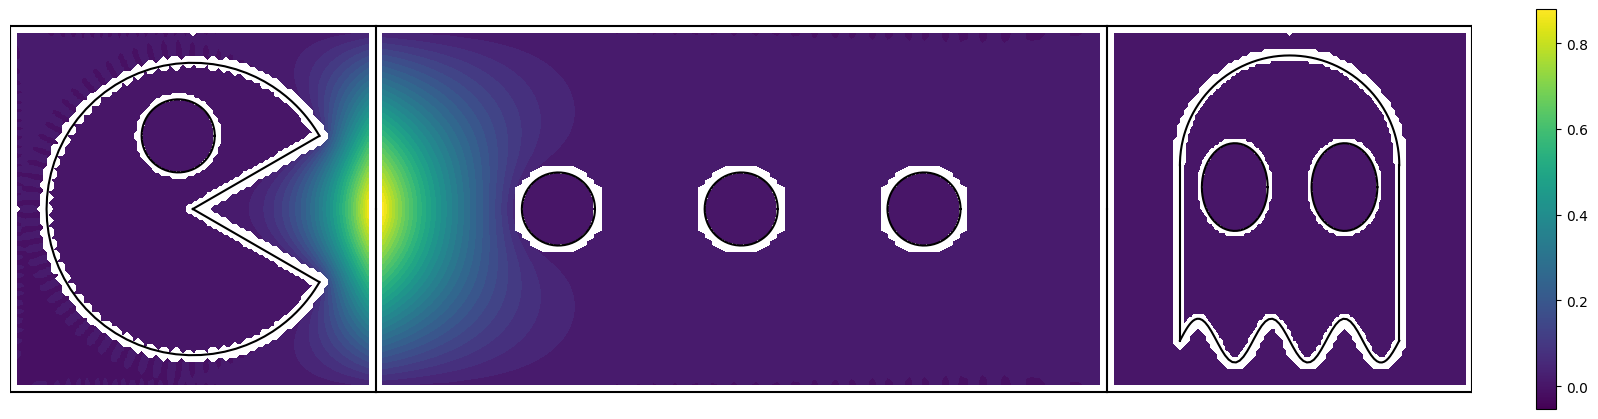

 42%|████▏     | 16/38 [01:30<02:05,  5.72s/it]

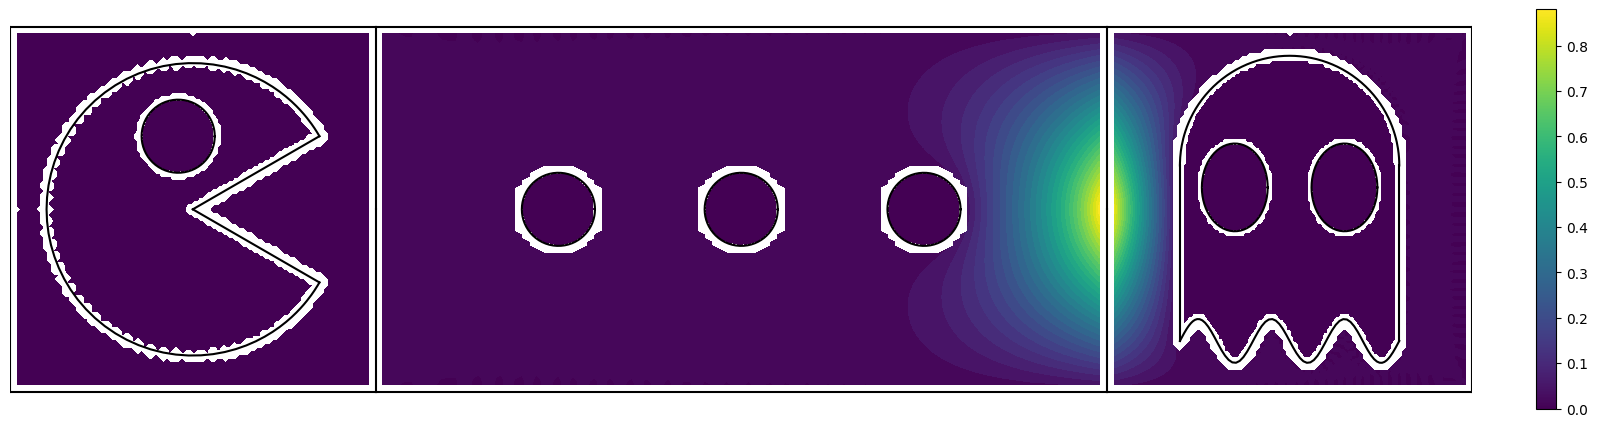

 45%|████▍     | 17/38 [01:37<02:05,  5.96s/it]

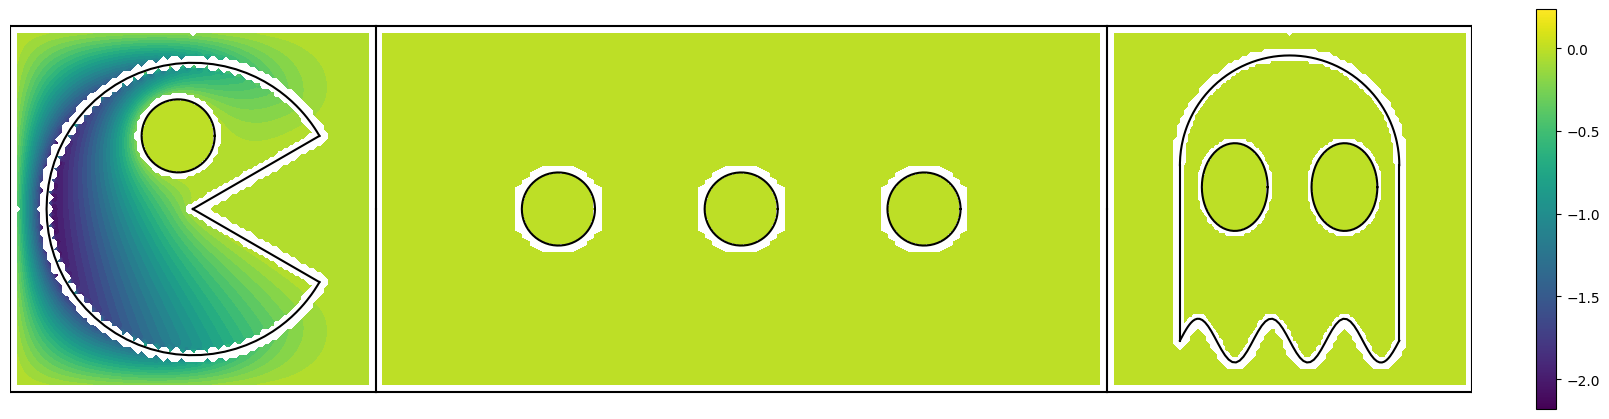

 47%|████▋     | 18/38 [01:43<01:57,  5.87s/it]

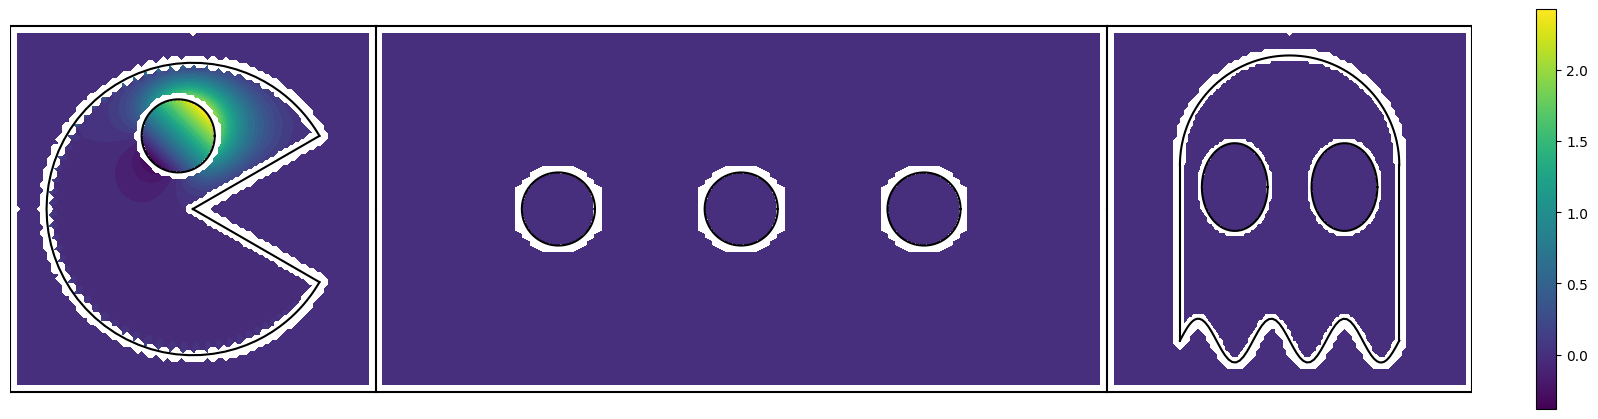

 50%|█████     | 19/38 [01:49<01:55,  6.09s/it]

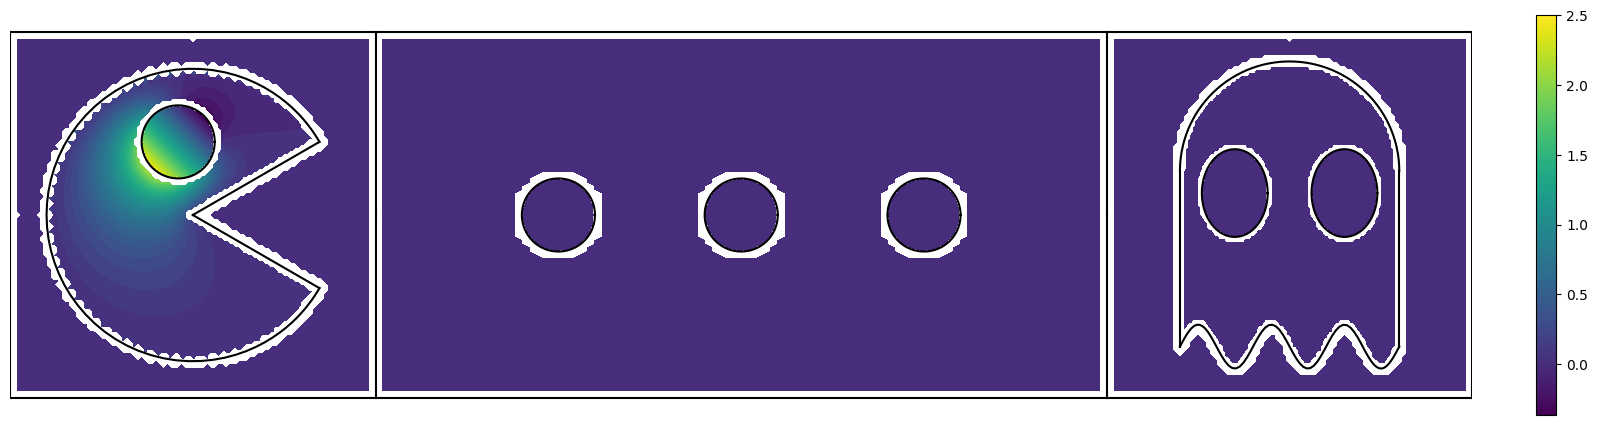

 53%|█████▎    | 20/38 [01:55<01:50,  6.11s/it]

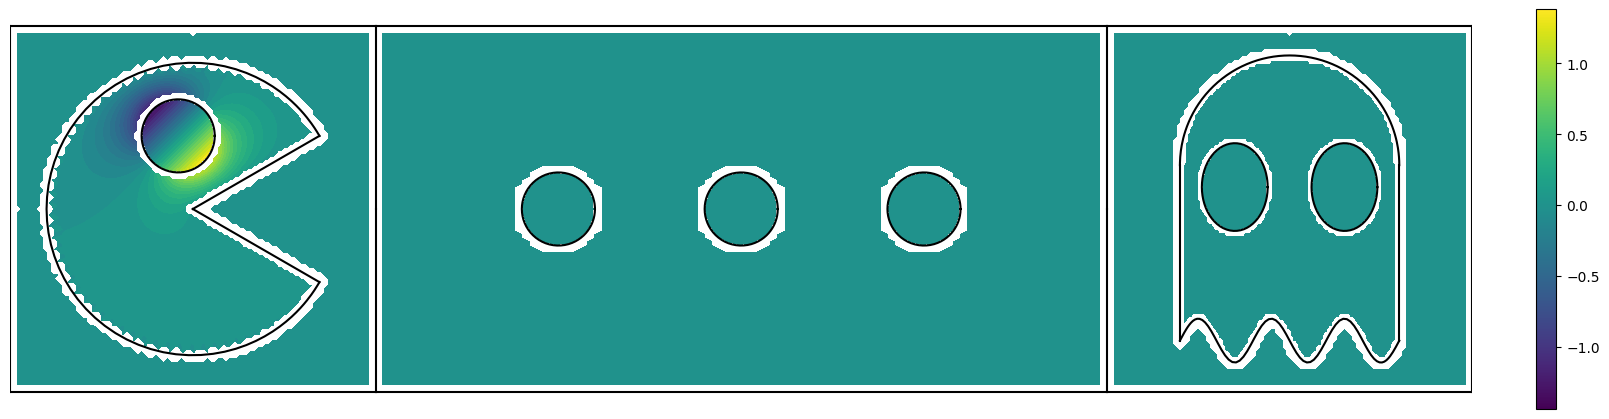

 55%|█████▌    | 21/38 [02:01<01:40,  5.92s/it]

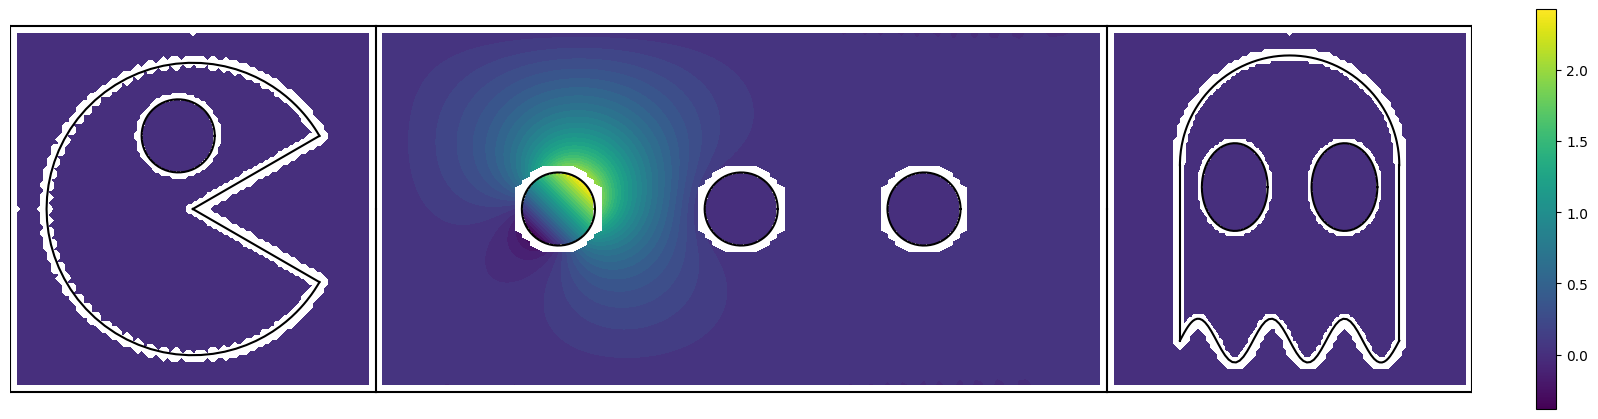

 58%|█████▊    | 22/38 [02:06<01:32,  5.76s/it]

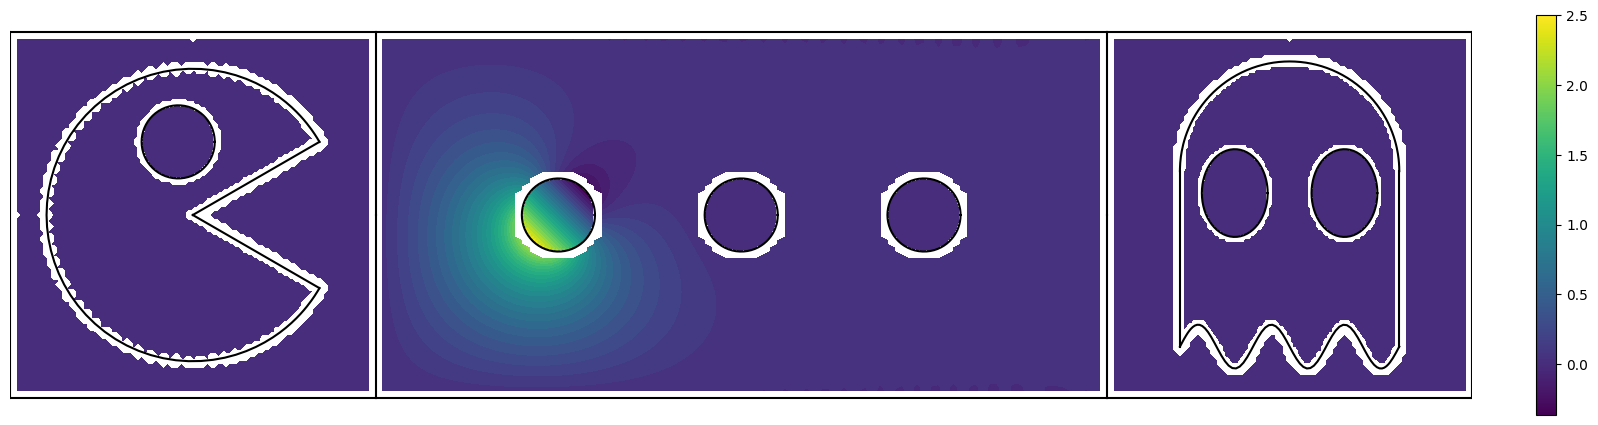

 61%|██████    | 23/38 [02:12<01:27,  5.81s/it]

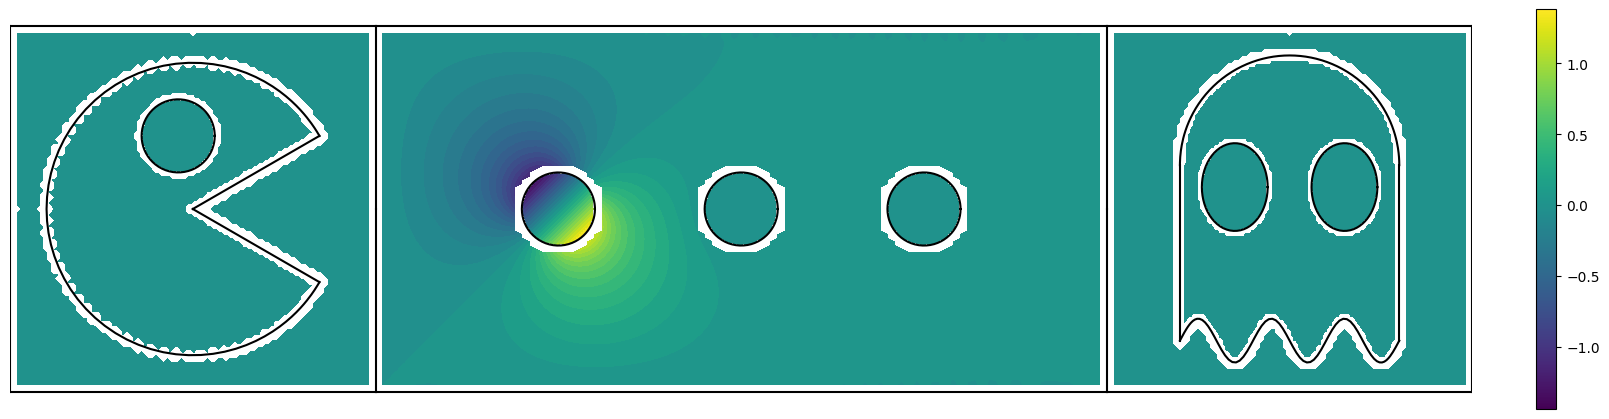

 63%|██████▎   | 24/38 [02:18<01:19,  5.69s/it]

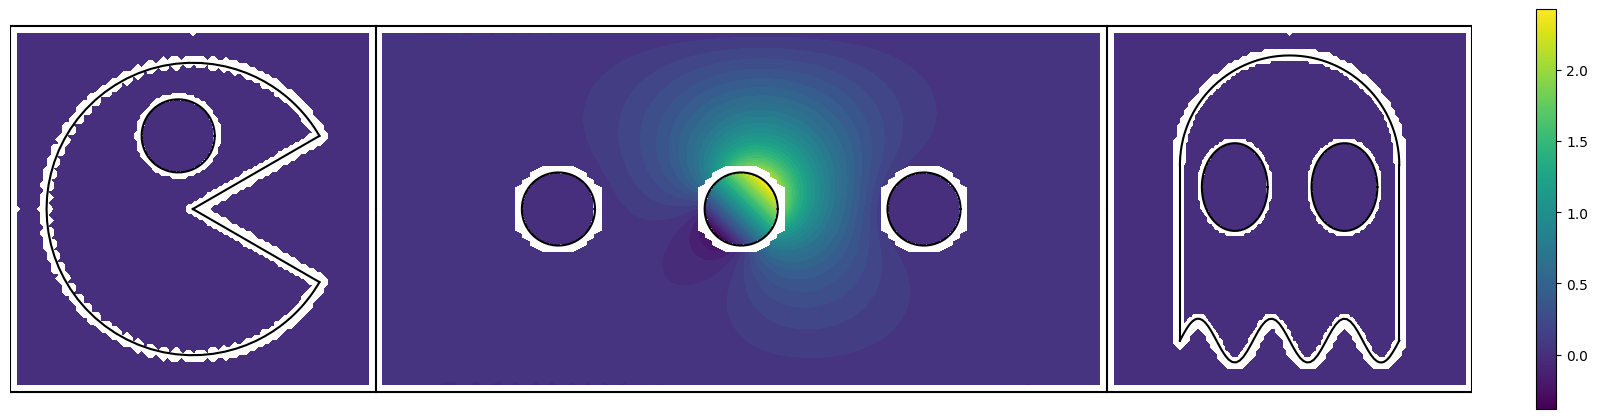

 66%|██████▌   | 25/38 [02:26<01:22,  6.38s/it]

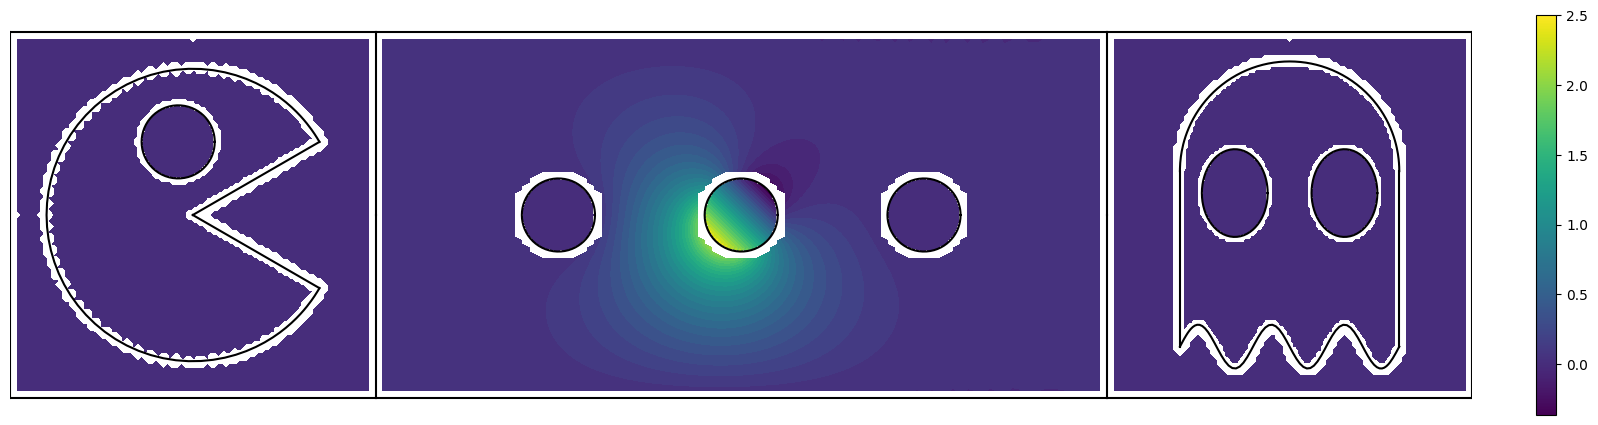

 68%|██████▊   | 26/38 [02:32<01:16,  6.40s/it]

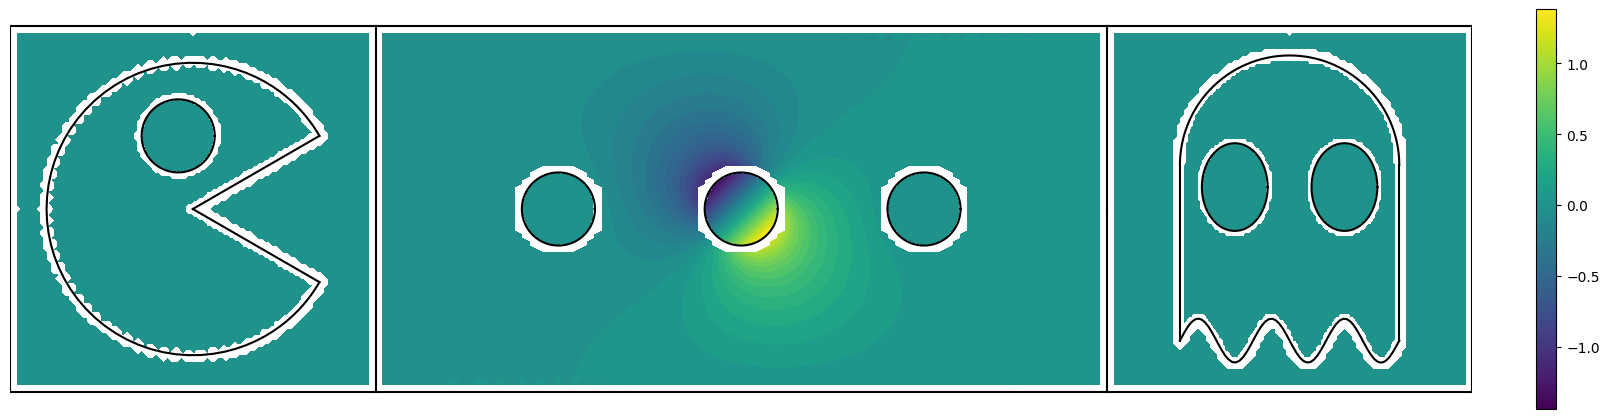

 71%|███████   | 27/38 [02:38<01:08,  6.23s/it]

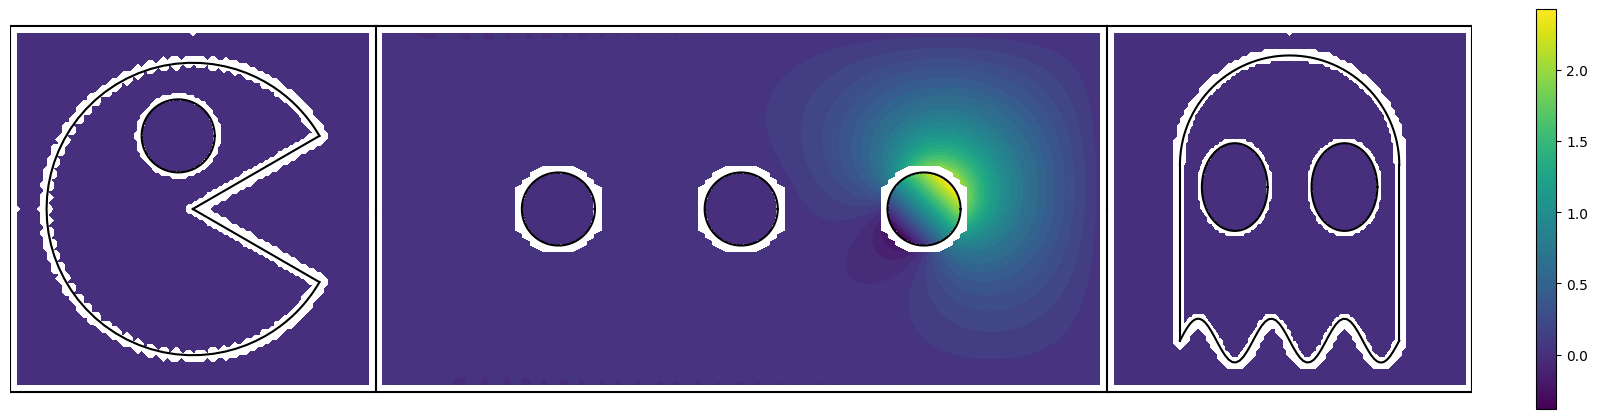

 74%|███████▎  | 28/38 [02:44<01:02,  6.26s/it]

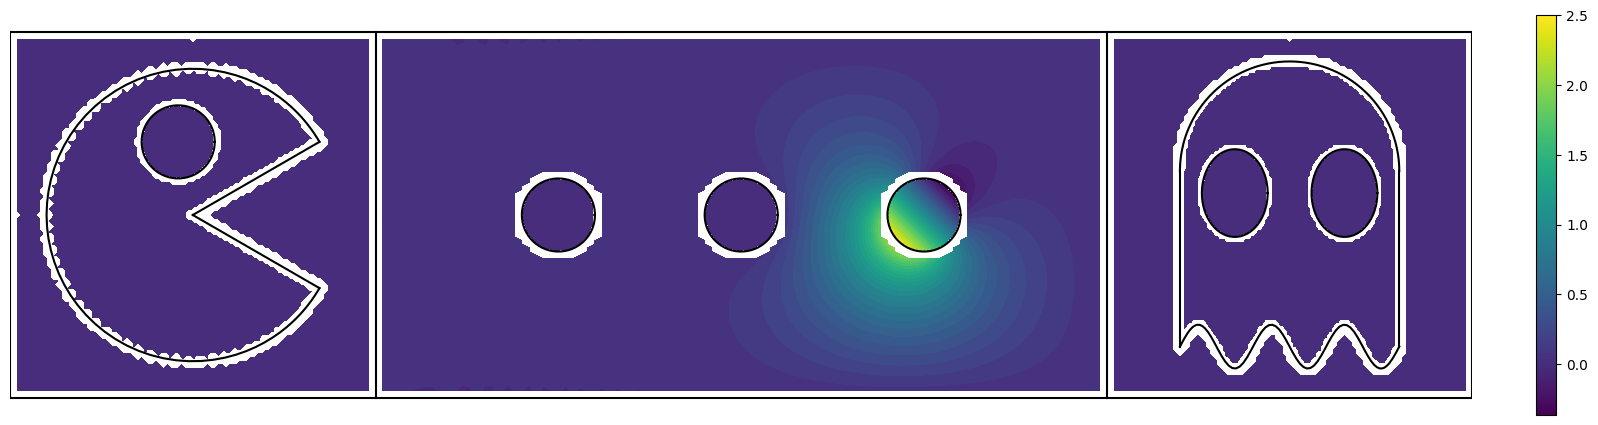

 76%|███████▋  | 29/38 [02:50<00:54,  6.04s/it]

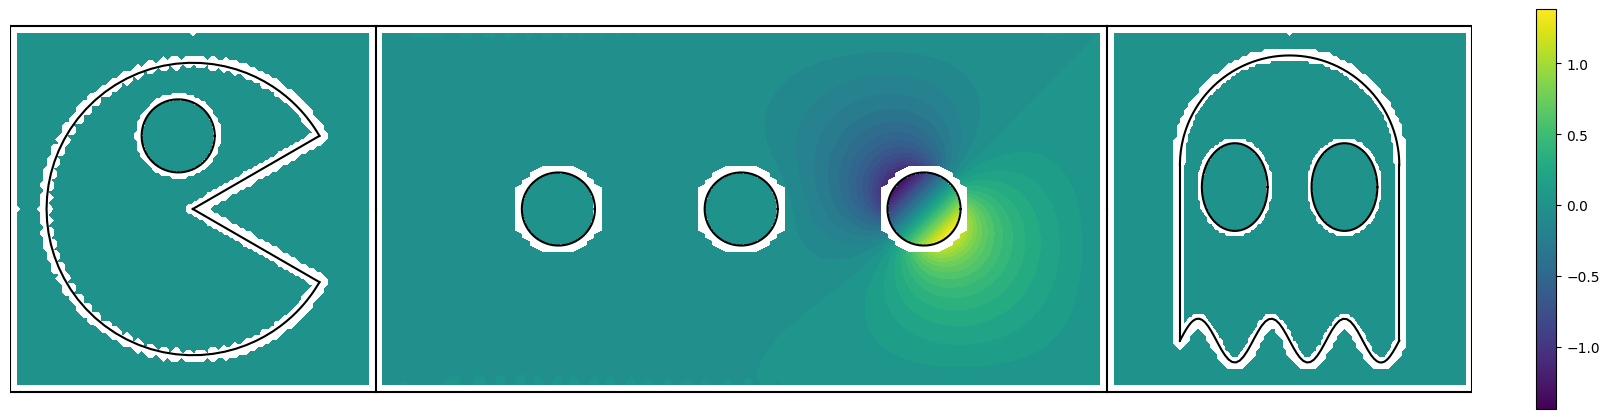

 79%|███████▉  | 30/38 [02:58<00:53,  6.64s/it]

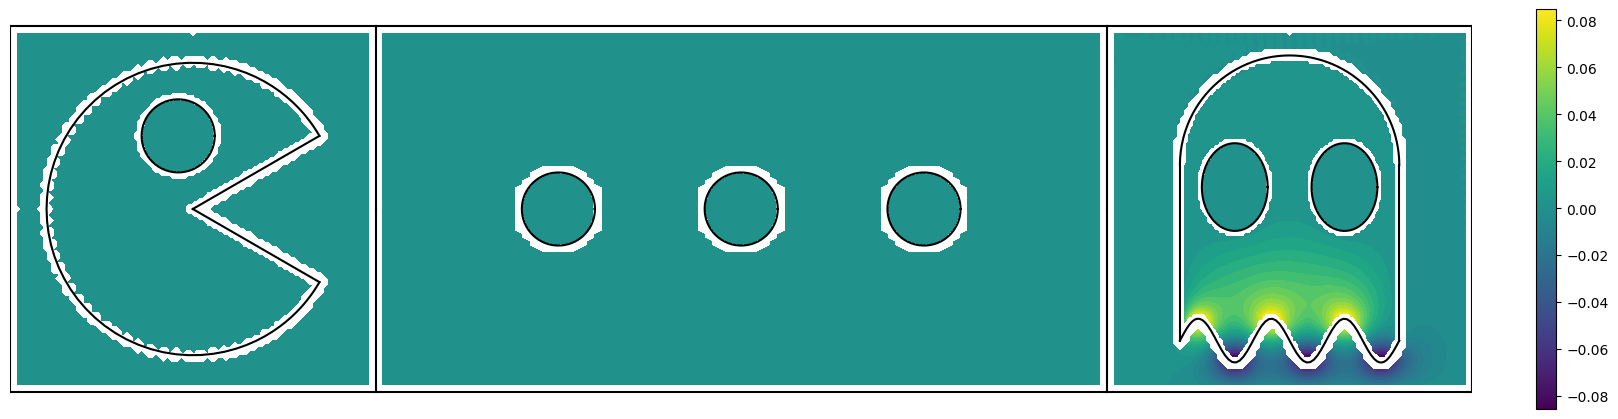

 82%|████████▏ | 31/38 [03:03<00:44,  6.29s/it]

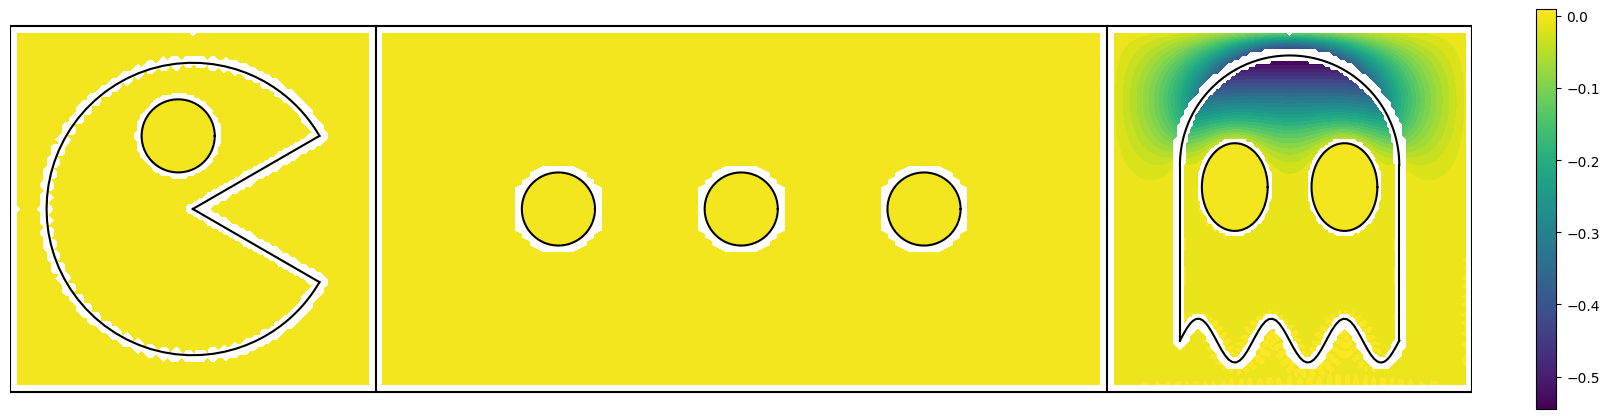

 84%|████████▍ | 32/38 [03:09<00:36,  6.03s/it]

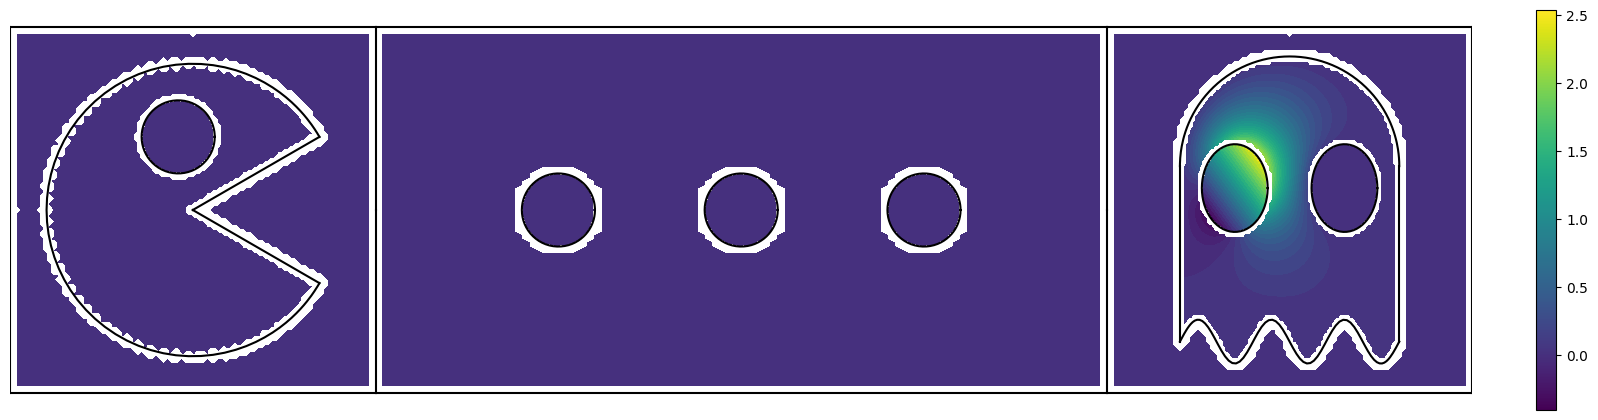

 87%|████████▋ | 33/38 [03:17<00:33,  6.60s/it]

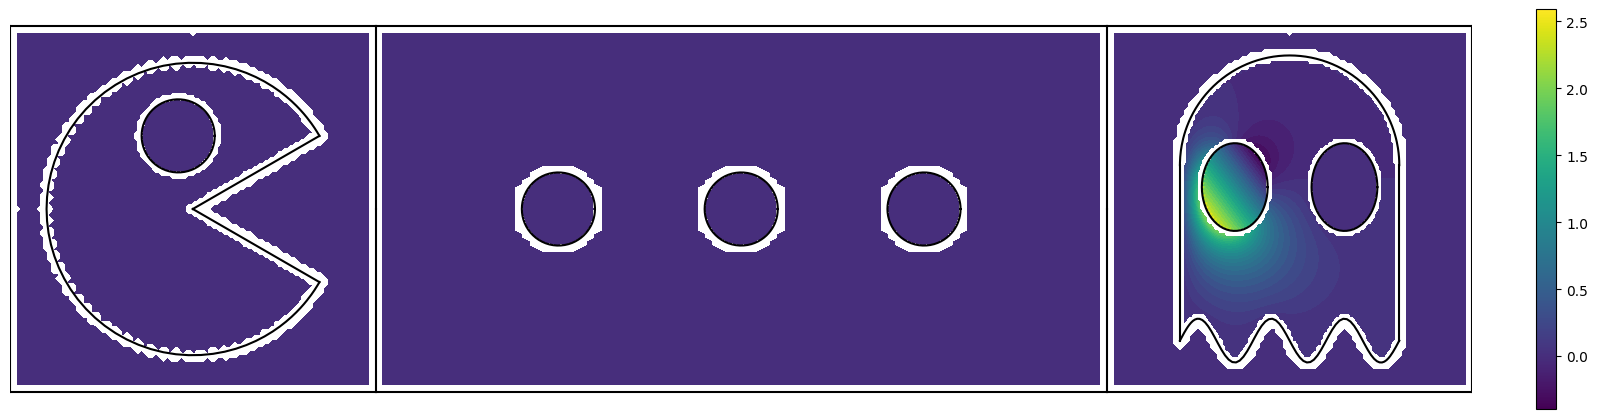

 89%|████████▉ | 34/38 [03:22<00:25,  6.29s/it]

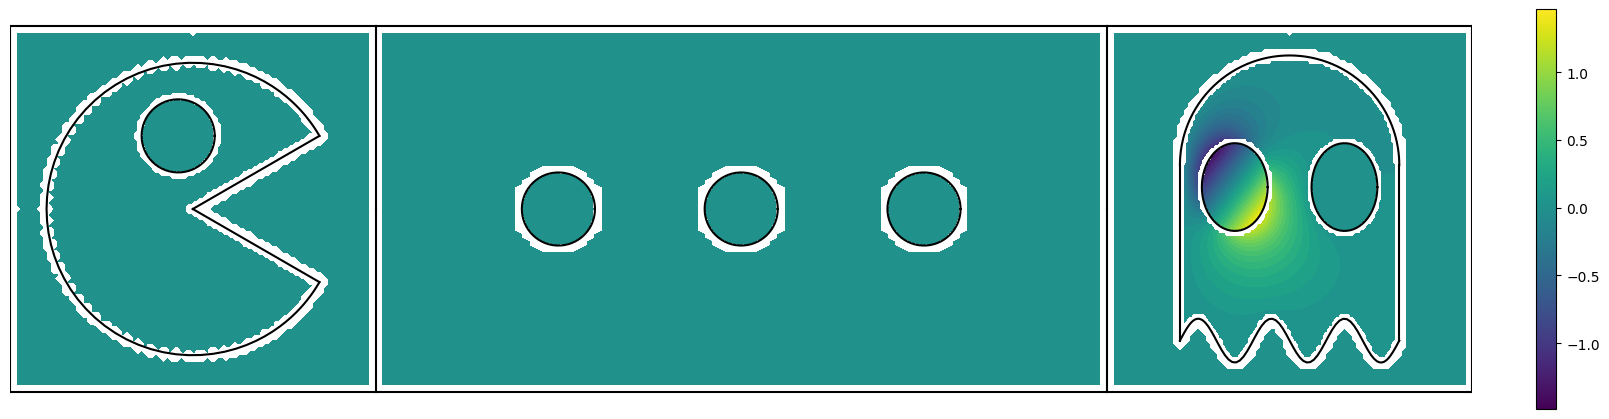

 92%|█████████▏| 35/38 [03:28<00:18,  6.10s/it]

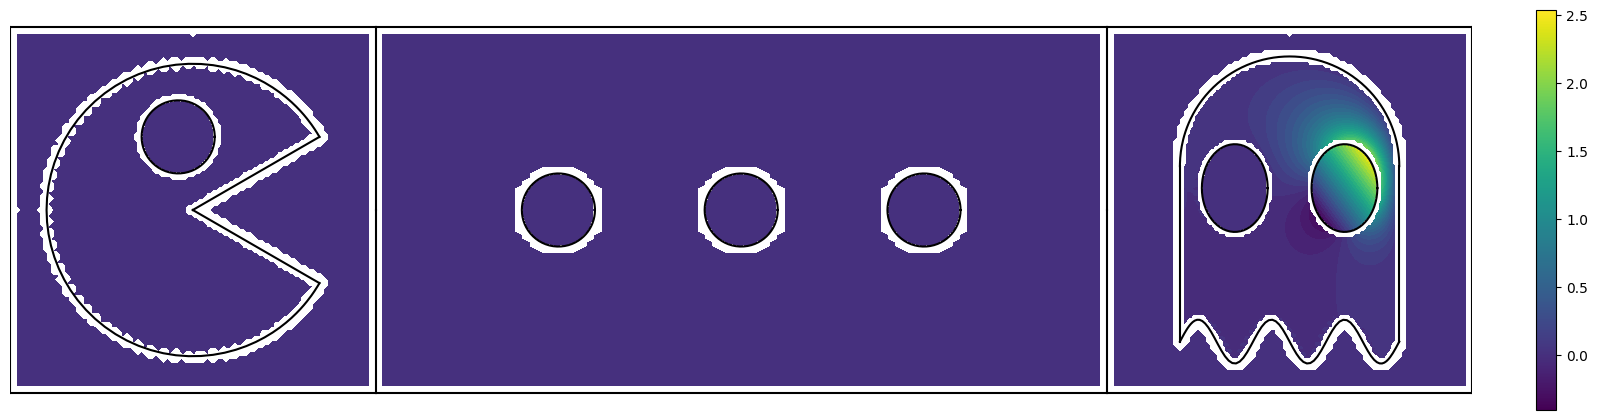

 95%|█████████▍| 36/38 [03:34<00:12,  6.05s/it]

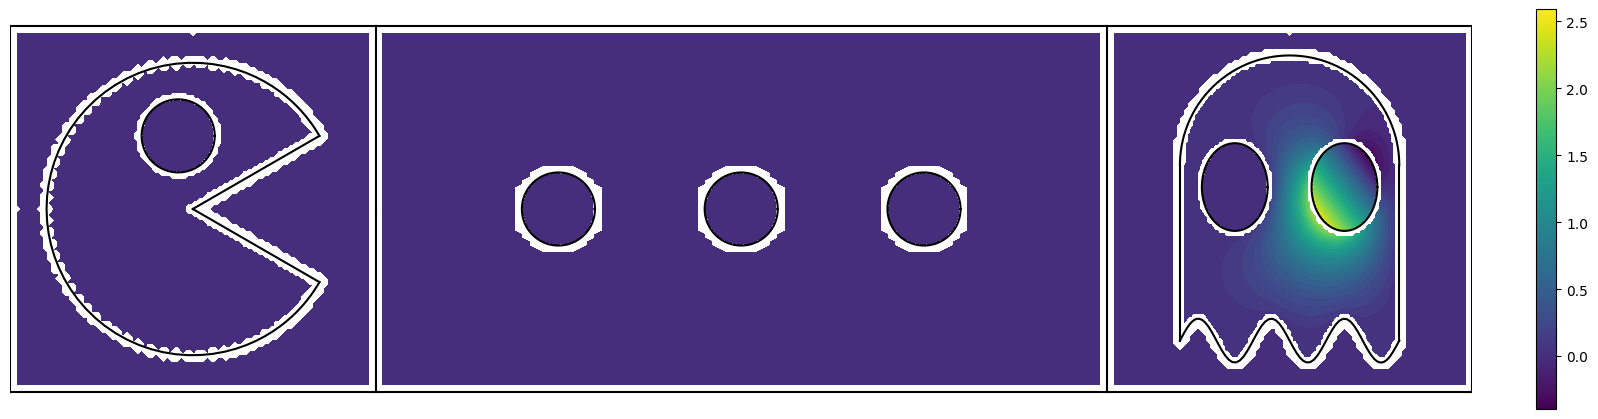

 97%|█████████▋| 37/38 [03:40<00:05,  5.99s/it]

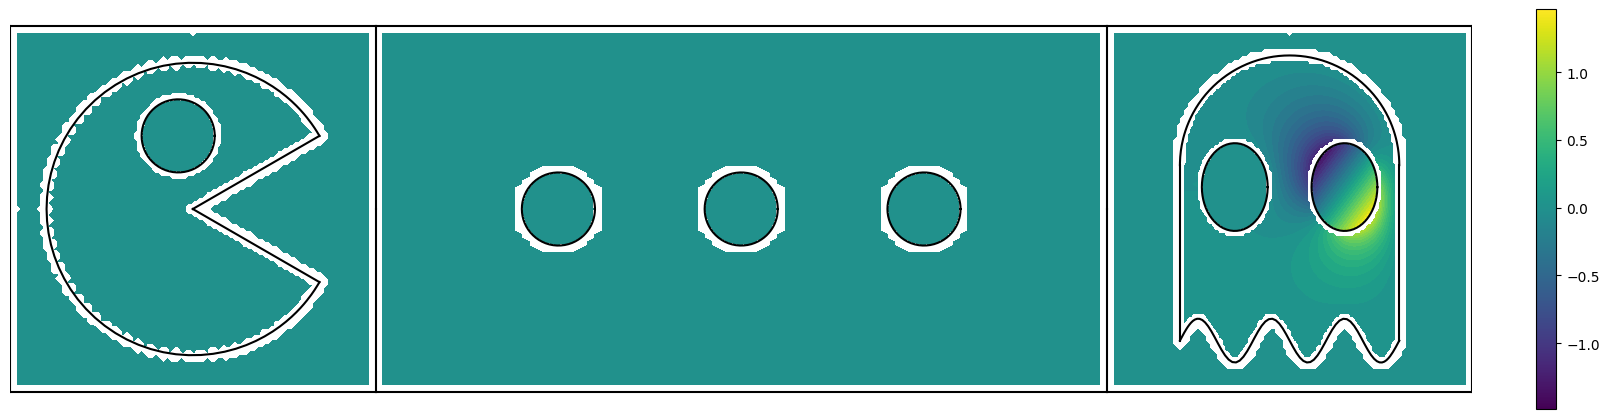

100%|██████████| 38/38 [03:45<00:00,  5.95s/it]


In [12]:
# decide if to use a progress bar
if verbose:
    print("Plotting basis functions...")
    basis_idx_list = tqdm(range(S.num_funs))
else:
    basis_idx_list = range(S.num_funs)

# plot each basis function
for idx in basis_idx_list:
    u = np.zeros(V.num_funs)
    u[idx] = 1.0
    S.plot_linear_combo(
        u,
        show_fig=True,
        save_fig=False,
        filename="out/png/basis_fun_%d.png" % idx,
        fill=True,
    )